# Non negative Matrix Factorization algorithm for movie recommendation

In this project, non negative matrix factorization algorithm is used to make movie recommendations to users.This technique learns a low-rank representation of the user-movies matrix and finds similar user's ratings to make recommendations. 

In [1]:
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv

## Import and prepare data

In [2]:
train_data = pd.read_csv('mf-data/ratings.csv',header=None)
train_data = train_data.rename(columns={0:'user_id',1:'movie_id',2:'rating'})
pivot = train_data.pivot(index='user_id',columns='movie_id',values='rating')

In [4]:
cols = pivot.columns 
total = range(1,1683)
diff = set(total)-set(cols)

In [5]:
for d in diff:
    pivot[d] = np.nan
M_matrix = np.array(pivot)

In [6]:
cols = pivot.columns

mydict = dict()
c=0
for col in cols:
    mydict[col]=c
    c=c+1

## Matrix factorization code

In [7]:
# code to create omega_u and omega
c=0
omega_u = dict()
omega = []
for row in M_matrix:
    values = []
    c1=0
    for val in row:
        if not math.isnan(val):
            values.append(c1)
            omega.append((c,c1))
        c1=c1+1
    omega_u[c] = values
    c=c+1

In [8]:
objects = M_matrix.shape[1]
users = M_matrix.shape[0]

In [9]:
def mf(v,omega):
    
    obj_all = []
    best_u = 0
    best_v = 0
    for iteration in range(0,100):

        ulist = []
        vlist = []
        obj = 0

        for i in range(0,users):
            
            f_term = inv(0.25*cov + np.matmul(v[~np.isnan(M_matrix[i])].T, v[~np.isnan(M_matrix[i])]))
            s_term = np.matmul(np.matrix(M_matrix[i][~np.isnan(M_matrix[i])]), v[~np.isnan(M_matrix[i])])
            ulist.append(np.matmul(f_term,s_term.T).T)

        u = np.squeeze(np.asarray(ulist))

        for j in range(0,objects):
            
            f_term1 = inv(0.25*cov + np.matmul(u[~np.isnan(M_matrix.T[j])].T, u[~np.isnan(M_matrix.T[j])]))
            s_term1 = np.matmul(np.matrix(M_matrix.T[j][~np.isnan(M_matrix.T[j])]), u[~np.isnan(M_matrix.T[j])])
            vlist.append(np.matmul(f_term1,s_term1.T).T)
            
        v = np.squeeze(np.asarray(vlist))

        first = np.nansum(np.multiply(M_matrix-np.matmul(u,v.T),M_matrix-np.matmul(u,v.T)))/(2*0.25)
        second = np.sum(np.square(np.linalg.norm(u,axis=0))/2)
        third = np.sum(np.square(np.linalg.norm(v,axis=0))/2)
        obj = obj + (-first-second-third)
        obj_all.append(obj)
        

    return u,v,obj_all

## Run the coordinate ascent algorithm for 10 iterations

In [56]:
# initialise v
obj_all_runs = []
u_all = []
v_all = []
best_obj = float("-inf")
for runs in range(0,10):
    u_current = []
    v_current = []
    mu = np.zeros(10)
    cov = np.identity(10)
    listv = np.random.multivariate_normal(mu,cov,objects)
    v = np.array(listv)
    u,v,obj = mf(v,omega)
    obj_all_runs.append(obj)
    u_all.append(u)
    v_all.append(v)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [105]:
objs = []
for i in obj_all_runs:
    objs.append(i[-1])

[-90930.48464964534,
 -91081.90873388867,
 -91221.98158287109,
 -91185.20051417641,
 -91198.57787564764,
 -90933.0826003303,
 -91434.03335454252,
 -90939.35407209754,
 -91267.95978672661,
 -97248.72631352133]

## Visualize the convergence of the algorithm

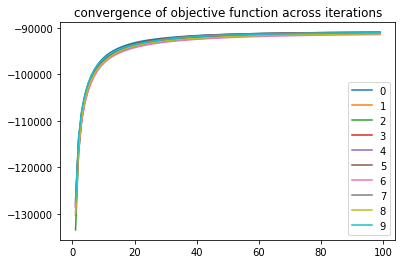

In [95]:
import matplotlib.pyplot as plt
c=0
for e in obj_all_runs:
    plt.plot(range(1,100),e[1:100],label=c)
    c=c+1
plt.legend()
plt.title("convergence of objective function across iterations")
plt.show()

In [58]:
test_data = pd.read_csv('mf-data/ratings.csv',header=None)
test_data = test_data.rename(columns={0:'user_id',1:'movie_id',2:'rating'})

In [59]:
rmse_all = []
for h in range(0,10):
    M_pred = np.matmul(u_all[h],v_all[h].T)
    s=0
    for index, row in test_data.iterrows():
        pred = M_pred[int(row['user_id'])-1, int(row['movie_id'])-1]
        s = s + (pred-obs)**2
    rmse = math.sqrt(s/len(test_data.index))
    rmse_all.append(rmse)

In [61]:
movies = pd.read_table('hw3-data/Prob3_movies.txt',header=None)

In [62]:
from scipy.spatial import distance

Star_Wars = movies[movies[0].str.contains('Star Wars')].index.item()
My_Fair_Lady = movies[movies[0].str.contains('My Fair Lady')].index.item()
GoodFellas = movies[movies[0].str.contains('GoodFellas')].index.item()

In [63]:
c=0
max_val = float("-inf")
for e in obj_all_runs:
    if max(e) > max_val:
        max_val = max(e)
        max_index = c
    c=c+1

In [64]:
best_u = u_all[max_index]
best_v = v_all[max_index]

## Movies nearby

In [127]:
for val in [Star_Wars,My_Fair_Lady,GoodFellas]:
    dist = []
    for i in range(0,best_v.shape[0]):
        dist.append(distance.euclidean(best_v[val], best_v[i]))
    print("\n")
    print("Top 10 movies near " + movies.loc[val].item())
    movies_nearby = movies[0][np.argsort(np.array(dist))[2:12]].values
    print(pd.DataFrame(data = {'movies' : movies_nearby,
                           'distances' : np.sort(np.array(dist))[2:12]}))
    print("\n")   



Top 10 movies near Star Wars (1977)
                                           movies  distances
0                  Raiders of the Lost Ark (1981)   0.454052
1                       Return of the Jedi (1983)   0.581678
2                      Princess Bride, The (1987)   0.660706
3                             Lost Horizon (1937)   0.714654
4       Indiana Jones and the Last Crusade (1989)   0.822184
5                      Blues Brothers, The (1980)   0.853641
6  Manon of the Spring (Manon des sources) (1986)   0.892771
7                                Toy Story (1995)   0.902124
8                      Usual Suspects, The (1995)   0.919417
9               Terminator 2: Judgment Day (1991)   0.933066




Top 10 movies near My Fair Lady (1964)
                            movies  distances
0              Little Women (1994)   1.020571
1       Sound of Music, The (1965)   1.060958
2       Singin' in the Rain (1952)   1.115607
3                Old Yeller (1957)   1.134799
4          Parent 